In [1]:
import hdf5storage
import h5py
import matplotlib.pyplot as plt
#from scipy.signal import istft
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import istft
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

In [2]:
name = "n0002_eeg"
rawfile_path = f"./sample/{name}.mat"
datafile_path = f"./sample/{name}_test.mat"

start_epoch = 5  # L=21 21개의 에폭들 중 6번째 에폭부터 11개 시각화
random_idx = 56  # L 길이의 window들 중 57번째

# 데이터 로드
with h5py.File(datafile_path, 'r') as data:
    spectrogram_data = np.array(data['input_x'])   # Shape: (1, 128, 29, 21, 705)
    spectrogram_data = spectrogram_data[0]          # Shape: (128, 29, 21, 705)
    spectrogram_data = np.moveaxis(spectrogram_data, -1, 0) # Shape: (705, 128, 29, 21)
    attention_weight = np.array(data['attention_weight'])
    yhat = np.array(data['yhat'])   # Shape: (21, 705)
    ytrue = np.array(data['ytrue'])  # Shape: (21, 705)

with h5py.File(rawfile_path, 'r') as data:
    raw_eeg = np.array(data['X1'])  # Shape: (3000, 725)

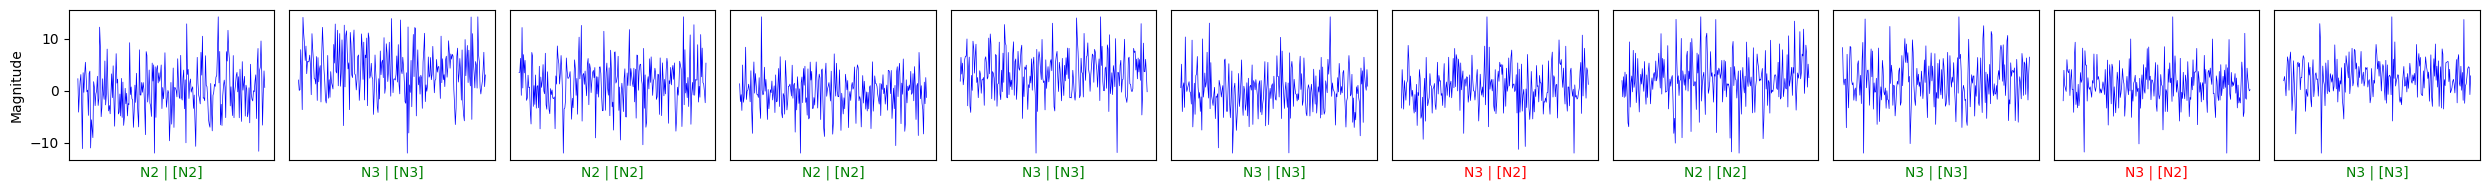

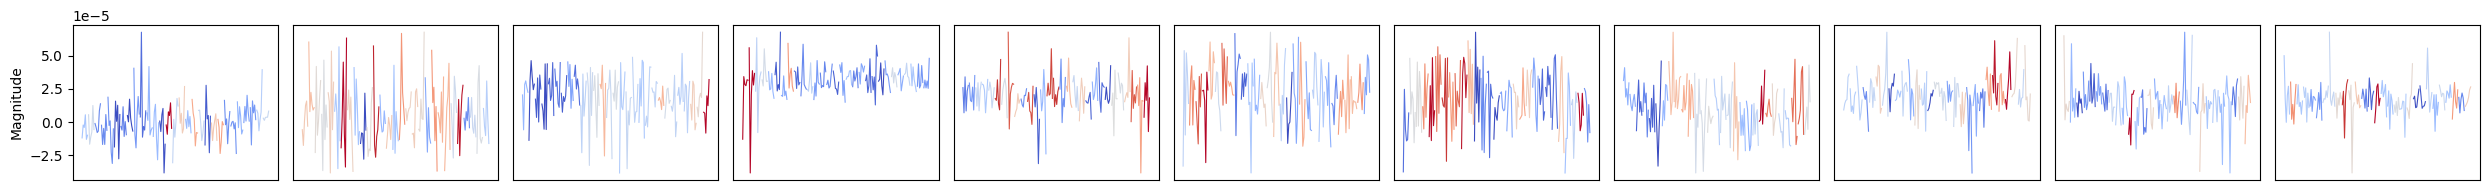

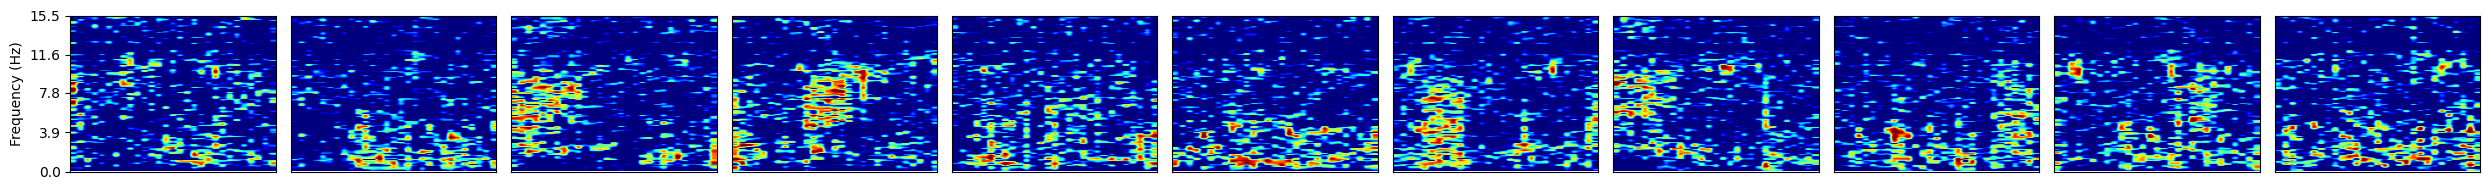

In [ ]:

# 샘플링 주파수 및 STFT 파라미터
fs = 100  
n_fft = 256  
hop_length = 128  
downsample_factor = 12  # 다운샘플링 비율 설정 (3000길이 다 시각화하면 보기 안좋음.. 논문저자도 다운샘플링한 것같음)

label_mapping = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}


def plot_reconstructed_eeg(spectrogram_data, yhat, ytrue, start_epoch, random_idx, num_epochs=11):
    """
    스펙트로그램으로부터 원복된 EEG 데이터에 대한 플롯을 생성하고 예측 및 실제 라벨을 x축에 표시.
    예측이 정확하면 초록색, 틀리면 빨간색으로 라벨을 표시.
    다운샘플링 적용.
    """
    selected_spectrogram = spectrogram_data[random_idx]  # Shape: (128, 29, 21)
    fig, axes = plt.subplots(1, num_epochs, figsize=(25, 2))

    for i in range(num_epochs):
        # yhat 및 ytrue 값 추출
        predicted_label = yhat[start_epoch + i, random_idx]
        true_label = ytrue[start_epoch + i, random_idx]
        predicted_label_mapped = label_mapping[predicted_label]
        true_label_mapped = label_mapping[true_label]

        # 색상 결정 (예측이 맞으면 초록색, 틀리면 빨간색)
        label_color = 'green' if predicted_label == true_label else 'red'
        
        # EEG 시각화
        spectrogram = selected_spectrogram[:, :, start_epoch + i]
        symmetric_spectrogram = np.pad(spectrogram, ((0, 256 - spectrogram.shape[0]), (0, 0)), mode='reflect')
        _, reconstructed_signal = istft(symmetric_spectrogram, fs=100, nperseg=256, noverlap=128)
        reconstructed_signal = reconstructed_signal[:3000]
        
        downsampled_signal = reconstructed_signal[::downsample_factor]
        
        axes[i].plot(downsampled_signal, color='blue', linewidth=0.5)
        
        # X축 레이블 설정
        axes[i].set_xlabel(f"{predicted_label_mapped} | [{true_label_mapped}]", color=label_color, fontsize=10)
        
        if i == 0:
            axes[i].set_ylabel("Magnitude", fontsize=10)
        else:
            axes[i].set_yticks([])
        axes[i].set_xticks([])

    plt.tight_layout()
    plt.show()

def plot_eeg_with_attention(raw_eeg, attention_weight, start_epoch, random_idx, num_epochs=11):
    """
    다운샘플링된 Raw EEG와 Attention Weight를 함께 시각화하는 함수
    """
    eeg_windows = [raw_eeg[:, i:i + 21] for i in range(raw_eeg.shape[1] - 21 + 1)]
    selected_eeg_window = eeg_windows[random_idx]
    selected_eeg_segments = np.array_split(selected_eeg_window, 29, axis=0)
    eeg_segments = selected_eeg_segments[start_epoch:start_epoch + num_epochs]
    selected_weight = attention_weight[:, start_epoch:start_epoch + num_epochs, random_idx]

    fig, axes = plt.subplots(1, num_epochs, figsize=(25, 2))
    color_map = cm.coolwarm

    for i in range(num_epochs):
        eeg_segment = eeg_segments[i].flatten()
        
        # 다운샘플링 적용
        downsampled_eeg_segment = eeg_segment[::downsample_factor]
        
        weight = selected_weight[:, i]
        normalized_weights = (weight - np.min(weight)) / (np.max(weight) - np.min(weight))
        colors = color_map(normalized_weights)
        
        segment_length = len(downsampled_eeg_segment) // len(weight)
        for j in range(len(weight)):
            start = j * segment_length
            end = (j + 1) * segment_length
            axes[i].plot(range(start, end), downsampled_eeg_segment[start:end], color=colors[j], linewidth=0.8)

        if i == 0:
            axes[i].set_ylabel("Magnitude", fontsize=10)
        else:
            axes[i].set_yticks([])
        axes[i].set_xticks([])

    plt.tight_layout()
    plt.show()

def plot_spectrogram(spectrogram_data, start_epoch, random_idx, num_epochs=11):
    """
    전체 데이터셋의 최소값과 최대값을 기준으로 정규화하여 스펙트로그램을 시각화하는 함수
    """
    selected_spectrogram = spectrogram_data[random_idx]  # Shape: (128, 29, 21)
    fig, axes = plt.subplots(1, num_epochs, figsize=(25, 2))

    # 전체 스펙트로그램 데이터에서 최소값과 최대값 계산 
    global_min = np.min(spectrogram_data)
    global_max = np.max(spectrogram_data)

    for i in range(num_epochs):
        spectrogram = selected_spectrogram[:, :, start_epoch + i]

        # 로그 스케일 적용 전 클리핑 (걍 잘 보이게 하려고)
        clipped_spectrogram = np.clip(spectrogram, 1e-3, None)  # 0.001보다 작은 값을 0.001로 클리핑
        log_spectrogram = np.log1p(clipped_spectrogram)  # 로그 스케일 적용
        norm_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))

        # 스펙트로그램 시각화 (컬러맵과 vmin, vmax 조정)
        im = axes[i].imshow(norm_spectrogram, aspect='auto', origin='lower', cmap='jet',  # 컬러맵을 'jet'로 변경
                            extent=[0, spectrogram.shape[1], 0, 15.5], vmin=0.1, vmax=0.9)  # vmin, vmax 조정

        if i == 0:
            axes[i].set_ylabel("Frequency (Hz)", fontsize=10)
            axes[i].set_yticks([0, 3.9, 7.8, 11.6, 15.5])  # y축 레이블 설정
        else:
            axes[i].set_yticks([])
        axes[i].set_xticks([])

    plt.tight_layout()
    plt.show()

plot_reconstructed_eeg(spectrogram_data, yhat, ytrue, start_epoch, random_idx)
plot_eeg_with_attention(raw_eeg, attention_weight, start_epoch, random_idx)
plot_spectrogram(spectrogram_data, start_epoch, random_idx)
